In [1]:
import numpy as np
!pip install spgl1
import sklearn
from sklearn import linear_model
import math
from sklearn.linear_model import OrthogonalMatchingPursuit
from spgl1 import spg_bpdn


import matplotlib.pyplot as plt

from helpers import *
from algorithms import *
from data_simulation import *

import csv
from scipy.integrate import odeint, solve_ivp
# import dat

In [2]:
# np.random.seed(1)

In [3]:
# def target_func(X): 
# # #     return np.exp(X[:,1]*X[:,2])+(np.sin(X[:,4]**2)) + X[:,3]*X[:,2] + X[:,7]
# #     return np.arctan(((520*np.pi*X[:,1] + 40*np.pi)*X[:,2] - 1/(((520*np.pi*X[:,1] + 40*np.pi)*X[:,2])*(10*X[:,3] + 1)))/(100*X[:,0]))
# #     return np.sqrt((100*X[:,0])**2 + ((520*np.pi*X[:,1] + 40*np.pi)*X[:,2] - 1/(((520*np.pi*X[:,1] + 40*np.pi)*X[:,2])*(10*X[:,3] + 1)))**2)
#     return 10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + 10*X[:,3] + 5*X[:,4]



def target_func(X):
#     s = 0
#     for i in range(X.shape[1]):
#         s += np.exp(-np.abs(X[:,i]))
#     return s
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = (1 + np.linalg.norm(X[i,:])**2)**(1/2)
    return y
#     return X[:,0]*X[:,1]/(1 + X[:,2]**6)

# # def target_func(X):
# #     return X[:,1]*X[:,8] + X[:,2]**2 + 6*X[:,3]**11


In [4]:
# np.random.seed(0)
num_data_train = 500 # number of data points for training data set
num_data_val = num_data_train #500 # number of data points for validation data set
num_data_tot = num_data_train + num_data_val
N = 16000 #5*num_data_train # number of features


'''parameters to be changed everytime'''
d = 200 # input dimension for target function; d<10 suggested
q = 2

mean = 0
std = 1.0

num_sets = 5 #number of to datasets
act = 'sin'
Dict_type = 'SRF'


In [5]:
mu = 0.1 #1/np.sqrt(N) #0.1 makes no diff
lam = 1e-12 #0.0000 #0.0000001 #1e-07-best ---makes difference. play
s = int(N*0.1) #------too much sparsity can make the errors fluctuate
e = 1e-09
iter_htp = 200


# X = np.random.uniform(0,1,(num_data_tot,d))
# Y = target_func(X)

In [6]:
mse_full = np.zeros(num_sets)
Rmse_full = np.zeros(num_sets)
relVal_error_full = np.zeros(num_sets)
sparsity_full = np.zeros(num_sets)
LossRegVal = np.zeros((num_sets,2))
iter_req = np.zeros(num_sets)
time_vec = np.zeros(num_sets)
time1 = np.zeros(num_sets)
task = 'func'
for i in range(num_sets):
#     X = make_input_data(rows = num_data_tot,columns = d,par1 = 0,par2 = 1,
#                     par3 = None,par4 = None,ratio = None,method = 'uni')
#     Y = target_func(X)
#     X_train, Y_train, X_val, Y_val = make_data_sets(X,Y,num_data_train,num_data_val)
#     plt.plot(Y_train)

    X_train = np.random.uniform(-1,1,(num_data_train,d))
    Y_train = target_func(X_train) 
#     Y_train/=np.linalg.norm(Y_train)
    X_val = np.random.uniform(-1,1,(num_data_val,d))
    Y_val = target_func(X_val) #/np.linalg.norm(Y_train)
#     plt.plot(X_train,Y_train,'.')
#     X_train = np.zeros((num_data_train,d))
#     X_val = np.zeros((num_data_val,d))
#     for j in range(d):
#         X_train[:,j] = np.random.uniform(0,1,num_data_train)
#         X_val[:,j] = np.random.uniform(0,1,num_data_val)
#     Y_train = target_func(X_train) 
#     Y_val = target_func(X_val)
    
    noise_train  = np.random.normal(mean,std,(Y_train.shape[0]))
    noise_val  = np.random.normal(mean,std,(Y_val.shape[0]))
    Y_train_noisy = Y_train #+ noise_train
    Y_val_noisy = Y_val #+ noise_val
    
    Omega,bias = generate_omega_bias(rows = N,columns = d,weight = 1,par1 = -1,par2 = 1,
                                       distribution = 'SRF',bool_bias = True,sparsity = q)
    
    A_train = dictionary_SRF(X_train,Omega,bias,activation = act,dictType = Dict_type)
    A_val = dictionary_SRF(X_val,Omega,bias,activation = act,dictType = Dict_type)
    
    scale_A = np.linalg.norm(A_train, axis = 0) 
#     scale_A = np.linalg.norm(A_train) 
    A_train /= scale_A 
    A_val /= scale_A
    
#     print(np.linalg.norm(A_train[:,0]),np.linalg.norm(A_train[:,5]))
          
    '''Run test using Hard Thresholding Pursuit'''
    c0_htp = np.zeros(A_train.shape[1])
    
    start_time = time.time()
    C_htp,error_htp,tot_iter_htp,sim,time1[i] = hard_thresh_pur_tik(A_train,Y_train_noisy,c0_htp,s,iter_htp,e,mu,lam)
    end_time = time.time()  
    
    print(C_htp.shape,np.count_nonzero(C_htp))
    time_vec[i] = end_time - start_time
    ytrain_rec_htp = np.matmul(A_train,C_htp)
    yval_rec_htp = np.matmul(A_val,C_htp)
    
    iter_req[i] = tot_iter_htp
    
    nnz_htp = sparsity(C_htp)
    error_train_htp = rel_error(A_train,C_htp,Y_train,task) 
    error_val_htp = rel_error(A_val,C_htp,Y_val,task)
    mseVal = np.linalg.norm(yval_rec_htp.flatten() - Y_val.flatten())**2/num_data_val
    RMSEVal = np.sqrt(mseVal)
    lossVal = np.linalg.norm(yval_rec_htp.flatten() - Y_val)**2
    regVal = np.linalg.norm(C_htp)**2
    
    mse_full[i] = mseVal
    Rmse_full[i] = RMSEVal
    relVal_error_full[i] = error_val_htp
    sparsity_full[i] =  nnz_htp
    LossRegVal[i,0] = lossVal
    LossRegVal[i,1] = regVal
#     if i%10==0:
#         print('the rmse is',RMSEVal,'at',i,'iter')
#         print(tot_iter_htp)
#         plot_hist_weights(C_htp[:,tot_iter_htp-1],s,d,Omega,Dict_type)

# mse = np.median(mse_full)
# rmse = np.median(Rmse_full)
# Val_error = np.median(relVal_error_full)

75.74930763380503 0.01457863239840309
1930.5653489994397 0.007240128511887026
1927.0994854337298 0.009297989453371694
41.24695242721992 0.021813801248356156
77.82006501353577 0.008115174627698667
92.94960480784574 0.009199656056357015
85.34278634403334 0.008041361334071257
77.42990769876056 0.0047692192667769555
Finally the total number of iterations the algorithm ran for was 9
(16000,) 682
75.92773480290232 0.004051504952261516
Finally the total number of iterations the algorithm ran for was 2
(16000,) 791
83.59426116945552 0.01530352200786217
1431.0192061848852 0.009860153639421526
1427.153655904963 0.0060959941444178
53.71660767953109 0.002185869102608468
Finally the total number of iterations the algorithm ran for was 5
(16000,) 814
84.26443878852976 0.004218910544732406
Finally the total number of iterations the algorithm ran for was 2
(16000,) 764
77.13112489333807 0.011209407578480492
82.81748877236107 0.0003154933236225461
Finally the total number of iterations the algorithm ra

In [7]:
mse = np.median(mse_full)
rmse = np.median(Rmse_full)
Val_error = np.mean(relVal_error_full)
tm1 = np.mean(time1)
tm = np.mean(time_vec)
iterations = np.mean(iter_req)
sparsity = np.median(sparsity_full)
loss = np.median(LossRegVal[:,0])
reg = np.median(LossRegVal[:,1])

print('\nMedian RMSE:',rmse,'\nMedian MSE:',mse,'\nMedian rel val error:',Val_error*100,
     '\nSparsity level:',sparsity,'\nLoss value is',loss,'\nRegularization value is',reg,
     '\ntime1 requires',tm,'\ntime_vec',np.mean(time_vec),'\nIterations req',iterations)

print('training error:',np.mean(error_train_htp))
# print('Val error:',np.mean(error_val_htp))



Median RMSE: 0.4344521487518576 
Median MSE: 0.18874866955510622 
Median rel val error: 5.017153269340365 
Sparsity level: 4.9437500000000005 
Loss value is 94.37433477755312 
Regularization value is 5765.020912299864 
time1 requires 3.471845006942749 
time_vec 3.471845006942749 
Iterations req 4.2
training error: 0.0003154933236225461


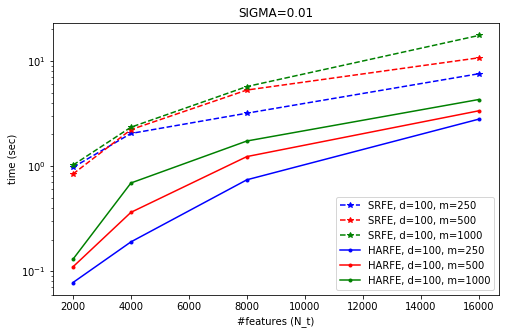

In [8]:
new = plt.figure(figsize=(8,5))
fig = new.add_subplot(111)
plt.semilogy([2000, 4000, 8000, 16000], [0.97,2.04,3.18,7.54] ,'b*--', label="SRFE, d=100, m=250")
plt.semilogy([2000, 4000, 8000, 16000], [0.84,2.22,5.28,10.69], 'r*--', label="SRFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [1.02,2.34,5.7,17.44], 'g*--', label="SRFE, d=100, m=1000")
plt.semilogy([2000, 4000, 8000, 16000], [0.078,0.19,0.74,2.79], 'b.-', label="HARFE, d=100, m=250")
plt.semilogy([2000, 4000, 8000, 16000], [0.11,0.3628,1.23,3.35], 'r.-', label="HARFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.13,0.69,1.73,4.29], 'g.-', label="HARFE, d=100, m=1000")
plt.legend(loc="best")
plt.xlabel("#features (N_t)")
plt.ylabel("time (sec)")
plt.title('SIGMA=0.01')
# plt.savefig("../plots/time.png", dpi=200, bbox_inches="tight")
plt.show()

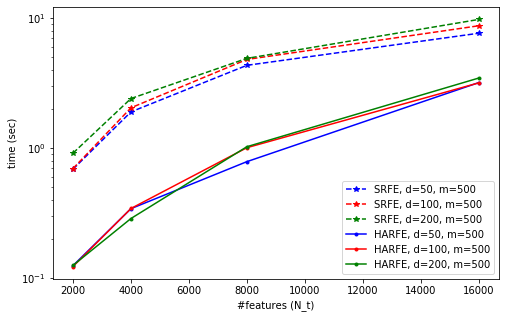

In [13]:
new = plt.figure(figsize=(8,5))
fig = new.add_subplot(111)
plt.semilogy([2000, 4000, 8000, 16000], [0.69015,1.90508,4.3467,7.673122] ,'b*--', label="SRFE, d=50, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.69799,2.0473,4.8222,8.76], 'r*--', label="SRFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.91666,2.4133,4.915,9.7962], 'g*--', label="SRFE, d=200, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.125,0.343,0.789,3.2013], 'b.-', label="HARFE, d=50, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.123,0.344,1.0101,3.185], 'r.-', label="HARFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.1255,0.288,1.028,3.47], 'g.-', label="HARFE, d=200, m=500")
plt.legend(loc="best")
plt.xlabel("#features (N_t)")
plt.ylabel("time (sec)")
# plt.title('Plot for different d')
# plt.savefig("../plots/time.png", dpi=200, bbox_inches="tight")
plt.show()

(16000,)


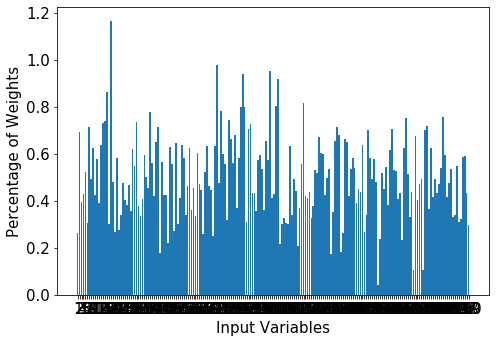

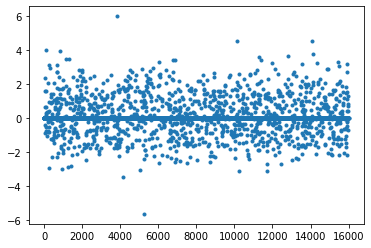

In [9]:
plot_hist_weights(C_htp,s,d,Omega,Dict_type)
plt.plot(C_htp,'.')

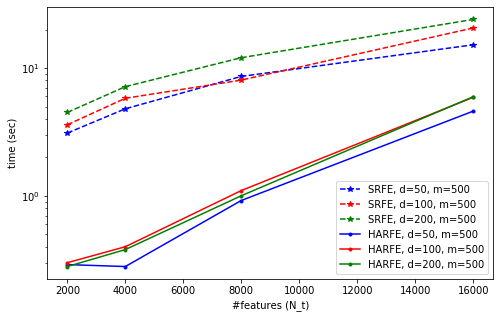

In [10]:
new = plt.figure(figsize=(8,5))
fig = new.add_subplot(111)
plt.semilogy([2000, 4000, 8000, 16000], [3.1,4.8,8.6,15.2] ,'b*--', label="SRFE, d=50, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [3.6,5.8,8.05,20.575], 'r*--', label="SRFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [4.5,7.15,12.05,24], 'g*--', label="SRFE, d=200, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.29,0.28,0.92,4.6], 'b.-', label="HARFE, d=50, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.3,0.4,1.1,5.9], 'r.-', label="HARFE, d=100, m=500")
plt.semilogy([2000, 4000, 8000, 16000], [0.28,0.38,1.002,5.963], 'g.-', label="HARFE, d=200, m=500")
plt.legend(loc="best")
plt.xlabel("#features (N_t)")
plt.ylabel("time (sec)")
# plt.savefig("../plots/time.png", dpi=200, bbox_inches="tight")
plt.show()

In [11]:
harfe_dim = np.array([[0.017,0.0087,0.0074],[0.1826,0.1249,0.0308],[0.388,0.8076,0.9876],[1.6991, 3.21,3.812]])
srfe_dim = np.array([[0.7,0.7,0.7],[1.2,1.2,1.2],[2.1,2.4,2.5],[4.3,4.4,4.4]])
features = np.array([1000,2000,4000,8000])
print('srfe time for m=500 is',srfe_time[:,1])

plt.plot(features,harfe_dim[:,0],'mx-',label = 'HARFE; d=50',linewidth = 2.5)
plt.plot(features,srfe_dim[:,0],'mo--',label = 'SRFE; d=50',linewidth = 2.5)

plt.plot(features,harfe_dim[:,1],'bx-',label = 'HARFE; d=100',linewidth = 2.5)
plt.plot(features,srfe_dim[:,1],'bo--',label = 'SRFE; d=100',linewidth = 2.5)

plt.plot(features,harfe_dim[:,2],'kx-',label = 'HARFE; d=200',linewidth = 2.5)
plt.plot(features,srfe_dim[:,2],'ko--',label = 'SRFE; d=200',linewidth = 2.5)

plt.xlabel('Features',fontsize = 15)
plt.ylabel('Time (s)',fontsize = 15)
plt.tick_params(labelsize = 15)
plt.title('Time taken for different N for m=500',fontsize = 15)
plt.legend()

plt.show()

NameError: name 'srfe_time' is not defined

In [ ]:
# np.savetxt('X_train_htprbest.csv', X_train, delimiter=',', fmt='%s')
# np.savetxt('X_val_htprbest.csv', X_val, delimiter=',', fmt='%s')
# np.savetxt('Y_train_htprbest.csv', Y_train, delimiter=',', fmt='%s')
# np.savetxt('Y_val_htprbest.csv', Y_val, delimiter=',', fmt='%s')


#m=500; N=1000: 0.0089
#m=500; N=2000: 0.052
#m=500; N=4000: 1.315
#m=500; N=8000: 4.8
